Gpu COre Show

=== ECLAT Benchmark on Google Colab ===

Environment Check:
Python version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
CuPy version: 13.3.0
CUDA available: True
Available CPU cores: 2
GPU 0: Tesla T4
  - CUDA Cores (estimated): 40960
  - Multiprocessors: 40
  - Max threads per MP: 1024
  - Memory: 15360 MB
Available memory: 12.7 GB

Loaded 50000 transactions from /content/retail.dat
Sample transaction: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
Total items: 511066
Average transaction length: 10.22
Unique items: 14414

Running benchmark with minimum support = 100
Scale factors: [0.2, 0.5, 1.0]

--- Processing 10000 Transactions (20%) ---
Testing GPU optimized implementation...
GPU detected, using optimized CuPy implementation
GPU optimized completed in 0.604s, found 204 itemsets
Testing GPU simple implementation...
GPU detected, using simple CuPy implementation
GPU simple completed in 2.883s, found 164 itemsets


/tmp/ipython-input-248738887.py:453: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


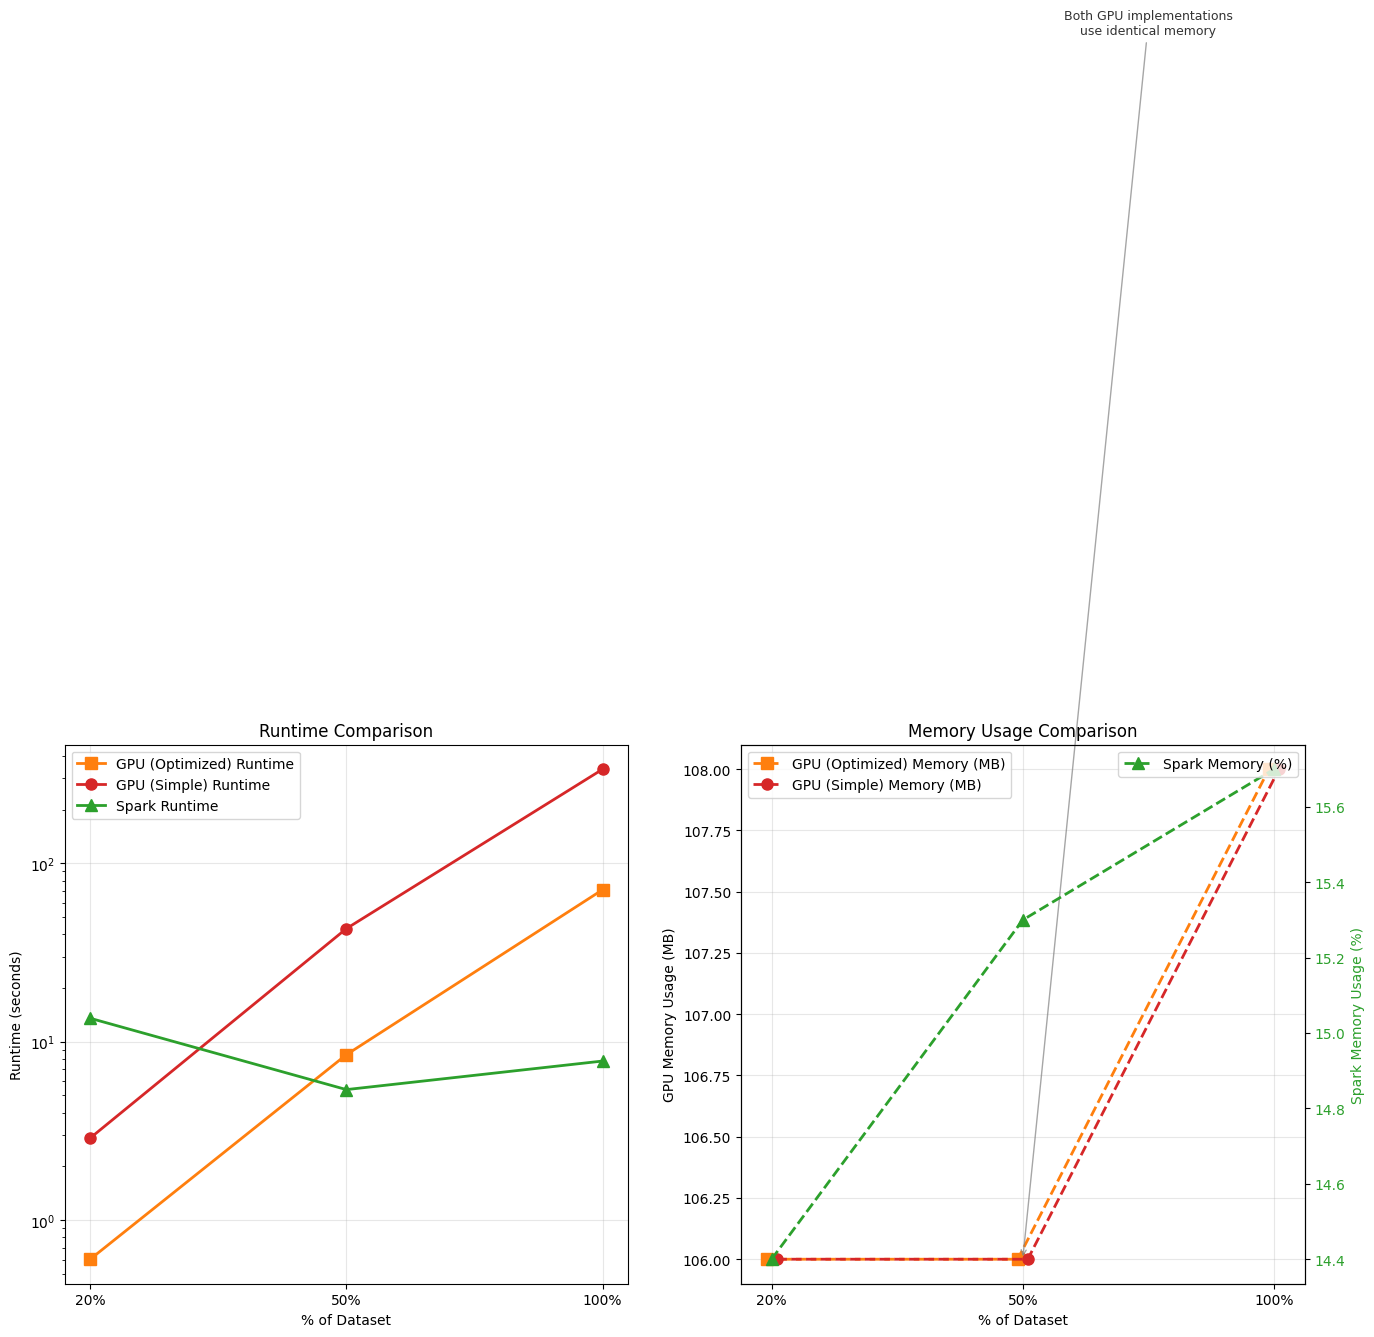


=== BENCHMARK SUMMARY ===
GPU (Optimized) average runtime: 26.698s
GPU (Simple) average runtime: 127.443s
Spark average runtime: 8.900s


In [ ]:
# Install required packages
# !pip install cupy-cuda12x GPUtil pyspark matplotlib psutil pyspark

import os
import time
import matplotlib.pyplot as plt
import cupy as cp
import psutil
import GPUtil
import csv
import numpy as np
from pyspark import SparkConf, SparkContext
from collections import defaultdict
import urllib.request
import zipfile

# ----------------------------
# Parameters
# ----------------------------
DATA_PATH = "/content/retail.dat"  # Path to dataset
MIN_SUPPORT = 100  # Increased for larger dataset
SCALE_FACTORS = [0.2, 0.5, 1.0]  # Test with 20k, 25k, and 50k transactions
TOP_K = 20

# ----------------------------
# Load and parse .dat retail dataset
# ----------------------------
def load_dataset(path, max_transactions=50000):
    """Load dataset with option to limit number of transactions"""
    with open(path, 'r') as f:
        transactions = []
        for i, line in enumerate(f):
            if line.strip():
                transactions.append(list(map(int, line.strip().split())))
                if len(transactions) >= max_transactions:
                    break
        return transactions

# ----------------------------
# ECLAT (Optimized GPU with CuPy)
# ----------------------------
def run_gpu(data, minsup):
    """Memory-efficient GPU ECLAT implementation"""
    try:
        cp.cuda.Device(0).compute_capability
        print("GPU detected, using optimized CuPy implementation")
    except:
        print("No GPU detected, skipping GPU implementation")
        return None

    # Build vertical representation using transaction ID lists (much more memory efficient)
    vertical = {}
    for tid, trans in enumerate(data):
        for item in trans:
            if item not in vertical:
                vertical[item] = []
            vertical[item].append(tid)

    # Filter by minimum support and convert to GPU arrays
    frequent_items = {}
    for item, tids in vertical.items():
        if len(tids) >= minsup:
            frequent_items[item] = cp.array(tids, dtype=cp.int32)

    results = []

    # Add 1-itemsets
    for item, tids in frequent_items.items():
        results.append(([item], len(tids)))

    def intersect_sorted(arr1, arr2):
        """Efficient intersection of two sorted GPU arrays"""
        return cp.intersect1d(arr1, arr2, assume_unique=True)

    def generate_candidates(items_dict, k):
        """Generate k-itemsets from (k-1)-itemsets"""
        candidates = []
        items_list = list(items_dict.items())

        for i in range(len(items_list)):
            for j in range(i + 1, len(items_list)):
                itemset1, tids1 = items_list[i]
                itemset2, tids2 = items_list[j]

                # Check if first k-2 items are the same
                if k > 2 and itemset1[:-1] != itemset2[:-1]:
                    continue

                # Create new candidate
                if k == 2:
                    new_itemset = [itemset1[0], itemset2[0]]
                else:
                    new_itemset = list(itemset1) + [itemset2[-1]]

                # Intersect transaction lists
                new_tids = intersect_sorted(tids1, tids2)
                support = len(new_tids)

                if support >= minsup:
                    candidates.append((new_itemset, new_tids))
                    results.append((new_itemset, support))

        return candidates

    # Generate 2-itemsets, 3-itemsets, etc.
    k = 2
    current_items = {tuple([item]): tids for item, tids in frequent_items.items()}

    while current_items and k <= 3:  # Limit to 3-itemsets to avoid memory issues
        candidates = generate_candidates(current_items, k)
        if not candidates:
            break

        # Prepare for next iteration
        current_items = {tuple(itemset): tids for itemset, tids in candidates}
        k += 1

        # Memory cleanup every iteration
        try:
            cp.get_default_memory_pool().free_all_blocks()
        except:
            pass

    # Final cleanup
    try:
        cp.get_default_memory_pool().free_all_blocks()
    except:
        pass

    return results

# ----------------------------
# ECLAT (Simple GPU - Fast Version)
# ----------------------------
def run_gpu_simple(data, minsup):
    """Simple GPU implementation for 1 and 2-itemsets only (much faster)"""
    try:
        cp.cuda.Device(0).compute_capability
        print("GPU detected, using simple CuPy implementation")
    except:
        return None

    # Count item frequencies
    item_count = {}
    for trans in data:
        for item in trans:
            item_count[item] = item_count.get(item, 0) + 1

    # Get frequent 1-itemsets
    frequent_1 = {item: count for item, count in item_count.items() if count >= minsup}
    results = [(item, count) for item, count in frequent_1.items()]

    # Build transaction vectors for frequent items only
    frequent_items = list(frequent_1.keys())

    if len(frequent_items) > 2000:  # Fallback if too many items
        print(f"Too many frequent items ({len(frequent_items)}), limiting to top 2000")
        # Sort by frequency and take top items
        sorted_items = sorted(frequent_1.items(), key=lambda x: -x[1])[:2000]
        frequent_items = [item for item, count in sorted_items]
        results = [(item, count) for item, count in sorted_items]

    # Create sparse representation
    item_vectors = {}
    for item in frequent_items:
        tids = []
        for tid, trans in enumerate(data):
            if item in trans:
                tids.append(tid)
        item_vectors[item] = cp.array(tids, dtype=cp.int32)

    # Generate 2-itemsets efficiently
    items_list = list(item_vectors.items())
    for i in range(len(items_list)):
        for j in range(i + 1, len(items_list)):
            item1, tids1 = items_list[i]
            item2, tids2 = items_list[j]

            # Intersect using GPU
            intersect_tids = cp.intersect1d(tids1, tids2)
            support = len(intersect_tids)

            if support >= minsup:
                results.append(([item1, item2], support))

    # Cleanup
    try:
        cp.get_default_memory_pool().free_all_blocks()
    except:
        pass

    return results

# ----------------------------
# ECLAT (Fully Distributed Spark)
# ----------------------------
def run_spark(data, minsup):
    # Configure Spark for Colab environment
    conf = SparkConf().setAppName("ECLAT_Spark") \
                    .setMaster("local[*]") \
                    .set("spark.driver.memory", "4g") \
                    .set("spark.executor.memory", "4g") \
                    .set("spark.sql.adaptive.enabled", "true") \
                    .set("spark.sql.adaptive.coalescePartitions.enabled", "true") \
                    .set("spark.serializer", "org.apache.spark.serializer.KryoSerializer")

    sc = SparkContext.getOrCreate(conf=conf)
    sc.setLogLevel("ERROR")

    try:
        rdd = sc.parallelize(data, numSlices=8)  # Increased partitions for better parallelization
        indexed_rdd = rdd.zipWithIndex()
        item_tid_rdd = indexed_rdd.flatMap(lambda x: [(item, x[1]) for item in set(x[0])])
        vertical_rdd = item_tid_rdd.groupByKey().mapValues(set).filter(lambda x: len(x[1]) >= minsup)
        vertical_dict = vertical_rdd.collectAsMap()
        items = sorted(vertical_dict.items())

        def local_eclat(partition_data):
            results = []
            def recurse(prefix, items):
                while items:
                    i, itids = items.pop()
                    support = len(itids)
                    if support >= minsup:
                        results.append((prefix + [i], support))
                        suffix = []
                        for j, o_tids in items:
                            tids = itids & o_tids
                            if len(tids) >= minsup:
                                suffix.append((j, tids))
                        recurse(prefix + [i], suffix)
            recurse([], list(partition_data))
            return results

        return local_eclat(items)
    finally:
        sc.stop()

# ----------------------------
# Utility Functions
# ----------------------------
def save_top_k(itemsets, path, k):
    if itemsets is None:
        return
    top_k = sorted(itemsets, key=lambda x: -x[1])[:k]
    with open(path, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["Itemset", "Support"])
        for items, support in top_k:
            if isinstance(items, list):
                writer.writerow([" ".join(map(str, items)), support])
            else:
                writer.writerow([str(items), support])

def get_usage():
    mem = psutil.virtual_memory()
    cpu_mem = mem.percent
    gpu_mem = 0
    try:
        gpus = GPUtil.getGPUs()
        if gpus:
            gpu_mem = sum([gpu.memoryUsed for gpu in gpus])
        else:
            gpu_mem = None
    except:
        gpu_mem = None
    return cpu_mem, gpu_mem

def save_logs_to_csv(runtimes, memlogs, path="runtime_memory_logs.csv"):
    headers = ["Scale", "GPU_Runtime", "GPU_Mem", "GPU_Simple_Runtime", "GPU_Simple_Mem", "Spark_Runtime", "Spark_Mem"]
    with open(path, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(headers)
        for i, factor in enumerate(SCALE_FACTORS):
            row = [
                f"{int(factor*100)}%",
                runtimes["GPU"][i] if "GPU" in runtimes and runtimes["GPU"][i] is not None else "N/A",
                memlogs["GPU"][i] if "GPU" in memlogs and memlogs["GPU"][i] is not None else "N/A",
                runtimes["GPU_Simple"][i] if "GPU_Simple" in runtimes and runtimes["GPU_Simple"][i] is not None else "N/A",
                memlogs["GPU_Simple"][i] if "GPU_Simple" in memlogs and memlogs["GPU_Simple"][i] is not None else "N/A",
                runtimes["Spark"][i] if "Spark" in runtimes and runtimes["Spark"][i] is not None else "N/A",
                memlogs["Spark"][i] if "Spark" in memlogs and memlogs["Spark"][i] is not None else "N/A",
            ]
            writer.writerow(row)

# ----------------------------
# Benchmarking
# ----------------------------
def benchmark(data):
    runtimes = {"GPU": [], "GPU_Simple": [], "Spark": []}
    memlogs = {"GPU": [], "GPU_Simple": [], "Spark": []}

    for factor in SCALE_FACTORS:
        subset_size = int(len(data) * factor)
        subset = data[:subset_size]
        minsup = MIN_SUPPORT
        print(f"\n--- Processing {subset_size} Transactions ({int(factor*100)}%) ---")

        # GPU Implementation (Optimized)
        print("Testing GPU optimized implementation...")
        try:
            start = time.time()
            gpu_result = run_gpu(subset, minsup)
            if gpu_result is not None:
                duration = time.time() - start
                cpu_mem, gpu_mem = get_usage()
                runtimes["GPU"].append(duration)
                memlogs["GPU"].append(gpu_mem)
                save_top_k(gpu_result, f"topk_gpu_{int(factor*100)}p.csv", TOP_K)
                print(f"GPU optimized completed in {duration:.3f}s, found {len(gpu_result)} itemsets")
            else:
                runtimes["GPU"].append(None)
                memlogs["GPU"].append(None)
                print("GPU optimized implementation not available")
        except Exception as e:
            print(f"GPU optimized implementation failed: {e}")
            runtimes["GPU"].append(None)
            memlogs["GPU"].append(None)

        # GPU Simple Implementation
        print("Testing GPU simple implementation...")
        try:
            start = time.time()
            gpu_simple_result = run_gpu_simple(subset, minsup)
            if gpu_simple_result is not None:
                duration = time.time() - start
                cpu_mem, gpu_mem = get_usage()
                runtimes["GPU_Simple"].append(duration)
                memlogs["GPU_Simple"].append(gpu_mem)
                save_top_k(gpu_simple_result, f"topk_gpu_simple_{int(factor*100)}p.csv", TOP_K)
                print(f"GPU simple completed in {duration:.3f}s, found {len(gpu_simple_result)} itemsets")
            else:
                runtimes["GPU_Simple"].append(None)
                memlogs["GPU_Simple"].append(None)
                print("GPU simple implementation not available")
        except Exception as e:
            print(f"GPU simple implementation failed: {e}")
            runtimes["GPU_Simple"].append(None)
            memlogs["GPU_Simple"].append(None)

        # Spark Implementation
        print("Testing Spark implementation...")
        try:
            start = time.time()
            spark_result = run_spark(subset, minsup)
            duration = time.time() - start
            cpu_mem, gpu_mem = get_usage()
            runtimes["Spark"].append(duration)
            memlogs["Spark"].append(cpu_mem)
            save_top_k(spark_result, f"topk_spark_{int(factor*100)}p.csv", TOP_K)
            print(f"Spark completed in {duration:.3f}s, found {len(spark_result)} itemsets")
        except Exception as e:
            print(f"Spark implementation failed: {e}")
            runtimes["Spark"].append(None)
            memlogs["Spark"].append(None)

    return runtimes, memlogs

# ----------------------------
# Fixed Plotting with Dual Y-Axes
# ----------------------------
def plot_results(runtimes, memlogs):
    labels = [f"{int(f * 100)}%" for f in SCALE_FACTORS]
    x = range(len(SCALE_FACTORS))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

    # Runtime plot
    ax1.set_xlabel("% of Dataset")
    ax1.set_ylabel("Runtime (seconds)")
    ax1.set_title("Runtime Comparison")

    methods = ["GPU", "GPU_Simple", "Spark"]
    colors = ['tab:orange', 'tab:red', 'tab:green']
    markers = ['s', 'o', '^']

    for i, method in enumerate(methods):
        if method in runtimes:
            valid_runtimes = [v if v is not None else float('nan') for v in runtimes[method]]
            label_name = "GPU (Optimized)" if method == "GPU" else "GPU (Simple)" if method == "GPU_Simple" else method
            ax1.plot(x, valid_runtimes, marker=markers[i], label=f'{label_name} Runtime',
                    color=colors[i], linewidth=2, markersize=8)

    ax1.set_xticks(x)
    ax1.set_xticklabels(labels)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_yscale('log')

    # Memory usage plot with dual y-axes
    ax2.set_xlabel("% of Dataset")
    ax2.set_title("Memory Usage Comparison")

    # Create second y-axis for percentage values
    ax2_right = ax2.twinx()

    # Left axis for GPU memory (MB)
    ax2.set_ylabel("GPU Memory Usage (MB)", color='black')
    ax2.tick_params(axis='y', labelcolor='black')

    # Right axis for Spark memory (%)
    ax2_right.set_ylabel("Spark Memory Usage (%)", color='tab:green')
    ax2_right.tick_params(axis='y', labelcolor='tab:green')

    # Plot GPU memory usage on left axis
    gpu_methods = ["GPU", "GPU_Simple"]
    gpu_colors = ['tab:orange', 'tab:red']
    gpu_markers = ['s', 'o']

    for i, method in enumerate(gpu_methods):
        if method in memlogs:
            valid_mem = [v if v is not None else float('nan') for v in memlogs[method]]
            label_name = "GPU (Optimized)" if method == "GPU" else "GPU (Simple)"

            # Offset the simple GPU line slightly to make both visible
            offset = 0.02 if method == "GPU_Simple" else -0.02
            x_offset = [xi + offset for xi in x]

            ax2.plot(x_offset, valid_mem, marker=gpu_markers[i], linestyle='--',
                    label=f'{label_name} Memory (MB)', color=gpu_colors[i],
                    linewidth=2, markersize=8)

    # Plot Spark memory usage on right axis
    if "Spark" in memlogs:
        valid_spark_mem = [v if v is not None else float('nan') for v in memlogs["Spark"]]
        ax2_right.plot(x, valid_spark_mem, marker='^', linestyle='--',
                    label='Spark Memory (%)', color='tab:green',
                    linewidth=2, markersize=8)

    # Set x-axis labels
    ax2.set_xticks(x)
    ax2.set_xticklabels(labels)
    ax2_right.set_xticks(x)
    ax2_right.set_xticklabels(labels)

    # Add legends
    ax2.legend(loc='upper left')
    ax2_right.legend(loc='upper right')

    # Add grids
    ax2.grid(True, alpha=0.3)

    # Add annotation to explain identical GPU memory usage
    if "GPU" in memlogs and "GPU_Simple" in memlogs:
        # Check if they have identical values
        gpu_mem = [v for v in memlogs["GPU"] if v is not None]
        gpu_simple_mem = [v for v in memlogs["GPU_Simple"] if v is not None]
        if gpu_mem and gpu_simple_mem and gpu_mem == gpu_simple_mem:
            ax2.annotate('Both GPU implementations\nuse identical memory',
                        xy=(1, gpu_mem[0]), xytext=(1.5, gpu_mem[0] + 5),
                        arrowprops=dict(arrowstyle='->', color='gray', alpha=0.7),
                        fontsize=9, ha='center', alpha=0.8)

    plt.tight_layout()
    plt.savefig("eclat_benchmark_colab.png", dpi=300, bbox_inches='tight')
    plt.show()

# ----------------------------
# Main execution
# ----------------------------
def main():
    print("=== ECLAT Benchmark on Google Colab ===")

    # Check environment
    print("\nEnvironment Check:")
    print(f"Python version: {os.sys.version}")

    try:
        import cupy as cp
        print(f"CuPy version: {cp.__version__}")
        print(f"CUDA available: {cp.cuda.is_available()}")
    except:
        print("CuPy not available")

    print(f"Available CPU cores: {os.cpu_count()}")

    # Check GPU cores
    try:
        gpus = GPUtil.getGPUs()
        if gpus:
            for i, gpu in enumerate(gpus):
                print(f"GPU {i}: {gpu.name}")
                # Try to get CUDA cores info
                try:
                    device = cp.cuda.Device(i)
                    attrs = device.attributes
                    multiprocessors = attrs['MultiProcessorCount']
                    max_threads_per_mp = attrs['MaxThreadsPerMultiProcessor']
                    cuda_cores = multiprocessors * max_threads_per_mp
                    print(f"  - CUDA Cores (estimated): {cuda_cores}")
                    print(f"  - Multiprocessors: {multiprocessors}")
                    print(f"  - Max threads per MP: {max_threads_per_mp}")
                    print(f"  - Memory: {gpu.memoryTotal:.0f} MB")
                except Exception as e:
                    print(f"  - Could not retrieve detailed GPU info: {e}")
        else:
            print("No GPU detected")
    except Exception as e:
        print(f"GPU detection failed: {e}")

    print(f"Available memory: {psutil.virtual_memory().total / (1024**3):.1f} GB")

    # Load and process data directly from DATA_PATH
    try:
        data = load_dataset(DATA_PATH, max_transactions=50000)
        print(f"\nLoaded {len(data)} transactions from {DATA_PATH}")
        print(f"Sample transaction: {data[0] if data else 'None'}")

        # Display dataset statistics
        if data:
            total_items = sum(len(transaction) for transaction in data)
            avg_transaction_length = total_items / len(data)
            unique_items = set(item for transaction in data for item in transaction)
            print(f"Total items: {total_items}")
            print(f"Average transaction length: {avg_transaction_length:.2f}")
            print(f"Unique items: {len(unique_items)}")

    except Exception as e:
        print(f"Error loading dataset from {DATA_PATH}: {e}")
        print("Please ensure the retail.dat file exists at /content/retail.dat")
        return

    # Run benchmark
    print(f"\nRunning benchmark with minimum support = {MIN_SUPPORT}")
    print(f"Scale factors: {SCALE_FACTORS}")

    results, memlogs = benchmark(data)

    # Save results
    save_logs_to_csv(results, memlogs)
    print(f"\nResults saved to runtime_memory_logs.csv")

    # Plot results
    plot_results(results, memlogs)

    # Display summary
    print("\n=== BENCHMARK SUMMARY ===")
    for method in ["GPU", "GPU_Simple", "Spark"]:
        if method in results and any(x is not None for x in results[method]):
            avg_time = sum(x for x in results[method] if x is not None) / len([x for x in results[method] if x is not None])
            method_name = "GPU (Optimized)" if method == "GPU" else "GPU (Simple)" if method == "GPU_Simple" else method
            print(f"{method_name} average runtime: {avg_time:.3f}s")
        else:
            method_name = "GPU (Optimized)" if method == "GPU" else "GPU (Simple)" if method == "GPU_Simple" else method
            print(f"{method_name}: Not available or failed")

if __name__ == "__main__":
    main()